In [58]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from biopsykit.classification.model_selection import SklearnPipelinePermuter

from pepbench.io import compute_abs_error

from pepbench.plotting.results import boxplot_algorithm_performance, _plot_helper_algorithm_performance

from fau_colors import cmaps, register_fausans_font

In [59]:
#register_fausans_font()
plt.close("all")

palette = sns.color_palette(cmaps.faculties)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.sans-serif"] = "FAUSans Office"

palette

[(0.0, 0.1843137254901961, 0.4235294117647059),
 (0.4666666666666667, 0.6235294117647059, 0.7098039215686275),
 (1.0, 0.7215686274509804, 0.10980392156862745),
 (0.0, 0.6392156862745098, 0.8784313725490196),
 (0.2627450980392157, 0.6901960784313725, 0.16470588235294117),
 (0.7843137254901961, 0.06274509803921569, 0.1803921568627451)]

In [60]:
data_path = Path("../../../results/data/b-point")
model_path = Path("../../../results/models/b-point")
output_image_path = Path("Images/Paper")

In [131]:
merged_ml_results_b_point_metrics = pd.read_csv(data_path.joinpath("merged_ml_results_b_point_error_metrics.csv"), index_col=[0,1,2,3,4])
merged_ml_results_b_point_metrics

arbol2017-isoelectric-crossings_rel_error  \
participant condition phase         heartbeat_id_reference arbol2017-isoelectric-crossings_error                                              
GDN0005     Dummy     HoldingBreath 0                      -50.0                                                                  -0.128866   
                                    1                       64.0                                                                   0.158416   
                                    3                      -6.0                                                                   -0.015957   
                                    4                      -4.0                                                                   -0.010256   
                                    5                      -12.0                                                                  -0.031088   
...                                                                                                                                     ...   
VP_032      tsst      Talk          39                     -25.0                                                                  -0.080645   
                                    40                     -9.0                                                                   -0.027950   
                                    41                      23.0                                                                   0.067647   
                                    42                     -54.0                                                                  -0.173633   
                                    43                     -35.0                                                                  -0.114007   

                                                                                                  arbol2017-isoelectric-crossings_abs_error  \
participant condition phase         heartbeat_id_reference arbol2017-isoelectric-crossings_error                                              
GDN0005     Dummy     HoldingBreath 0                      -50.0                                                                       50.0   
                                    1                       64.0                                                                       64.0   
                                    3                      -6.0                                                                         6.0   
                                    4                      -4.0                                                                         4.0   
                                    5                      -12.0                                                                       12.0   
...                                                                                                                                     ...   
VP_032      tsst      Talk          39                     -25.0                                                                       25.0   
                                    40                     -9.0                                                                         9.0   
                                    41                      23.0                                                                       23.0   
                                    42                     -54.0                                                                       54.0   
                                    43                     -35.0                                                                       35.0   

                                                                                                  arbol2017-isoelectric-crossings_abs_rel_error  \
participant condition phase         heartbeat_id_reference arbol2017-isoelectric-crossings_error                                                  
GDN0005     Dummy     HoldingBreath 0                      -50.0                    

In [130]:
merged_ml_results_b_point = pd.read_csv(data_path.joinpath("merged_ml_results_b_point.csv"), index_col=[0,1,2,3]).drop(columns=['level_0'])
merged_ml_results_b_point

b_point_sample_reference  \
participant condition phase         heartbeat_id_reference                             
GDN0005     Dummy     HoldingBreath 0                                          388.0   
                                    1                                          404.0   
                                    3                                          376.0   
                                    4                                          390.0   
                                    5                                          386.0   
...                                                                              ...   
VP_032      tsst      Talk          39                                         310.0   
                                    40                                         322.0   
                                    41                                         340.0   
                                    42                                         311.0   
                                    43                                         307.0   

                                                            arbol2017-isoelectric-crossings  \
participant condition phase         heartbeat_id_reference                                    
GDN0005     Dummy     HoldingBreath 0                                                 438.0   
                                    1                                                 340.0   
                                    3                                                 382.0   
                                    4                                                 394.0   
                                    5                                                 398.0   
...                                                                                     ...   
VP_032      tsst      Talk          39                                                335.0   
                                    40                                                331.0   
                                    41                                                317.0   
                                    42                                                365.0   
                                    43                                                342.0   

                                                            arbol2017-second-derivative  \
participant condition phase         heartbeat_id_reference                                
GDN0005     Dummy     HoldingBreath 0                                             398.0   
                                    1                                             350.0   
                                    3                                             296.0   
                                    4                                             344.0   
                                    5                                             312.0   
...                                                                                 ...   
VP_032      tsst      Talk          39                                            276.0   
                                    40                                            298.0   
                                    41                                            300.0   
                                    42                                            324.0   
                                    43                                            313.0   

                                                            arbol2017-third-derivative  \
participant condition phase         heartbeat_id_reference                               
GDN0005     Dummy     HoldingBreath 0                                            394.0   
                                    1                                            244.0   
                                    3                                            386.0   
                                    4        

### Best performing ML-Estimators
- ('StandardScaler', 'SelectFromModel', 'SVR') Data: Include RR-Interval
- ('StandardScaler', 'SelectKBest', 'RandomForestRegressor') Data: Without RR-Interval
- ('StandardScaler', 'SelectFromModel', 'SVR') Data: Without RR-Interval

In [70]:
algo_dict = {
    "drost2022_abs_error": "Dro22",
    "SS_SFM_SVR_RR-Interval_abs_error": "SVR RR-Interval",
    "SS_KBest_RFR_Without-RR-Interval_abs_error": "RFR",
    "SS_SFM_SVR_Without-RR-Interval_abs_error": "SVR",
}

In [132]:
plot_data = merged_ml_results_b_point_metrics[["drost2022_abs_error", "SS_SFM_SVR_RR-Interval_abs_error", "SS_KBest_RFR_Without-RR-Interval_abs_error", "SS_SFM_SVR_Without-RR-Interval_abs_error"]]
plot_data = plot_data.rename(columns=algo_dict)
plot_data

Dro22  \
participant condition phase         heartbeat_id_reference arbol2017-isoelectric-crossings_error          
GDN0005     Dummy     HoldingBreath 0                      -50.0                                   12.0   
                                    1                       64.0                                   16.0   
                                    3                      -6.0                                    10.0   
                                    4                      -4.0                                     6.0   
                                    5                      -12.0                                    6.0   
...                                                                                                 ...   
VP_032      tsst      Talk          39                     -25.0                                    8.0   
                                    40                     -9.0                                     0.0   
                                    41                      23.0                                    3.0   
                                    42                     -54.0                                   43.0   
                                    43                     -35.0                                   25.0   

                                                                                                  SVR RR-Interval  \
participant condition phase         heartbeat_id_reference arbol2017-isoelectric-crossings_error                    
GDN0005     Dummy     HoldingBreath 0                      -50.0                                        35.848261   
                                    1                       64.0                                         0.697432   
                                    3                      -6.0                                          0.097434   
                                    4                      -4.0                                          1.712398   
                                    5                      -12.0                                         0.324974   
...                                                                                                           ...   
VP_032      tsst      Talk          39                     -25.0                                         0.235136   
                                    40                     -9.0                                         10.291140   
                                    41                      23.0                                         7.615748   
                                    42                     -54.0                                        28.076117   
                                    43                     -35.0                                         2.711155   

                                                                                                        RFR  \
participant condition phase         heartbeat_id_reference arbol2017-isoelectric-crossings_error              
GDN0005     Dummy     HoldingBreath 0                      -50.0                                  30.747967   
                                    1                       64.0                                   0.497893   
                                    3                      -6.0                                    0.467924   
                                    4                      -4.0                                    1.112300   
                                    5                      -12.0                                   0.565148   
...                                                                                                     ...   
VP_032      tsst      Talk          39                     -25.0                                   6.434510   
                                    40                     -9.0                                   10.803013   
                                    41                      23.0          

In [129]:
empkins_data = plot_data.loc[plot_data.index.get_level_values(level="condition").isin(['ftsst', 'tsst'])]
guardian_data = plot_data.xs(key="Dummy", level="condition")

Boxplot of the best performing traditional- + ml-estimators

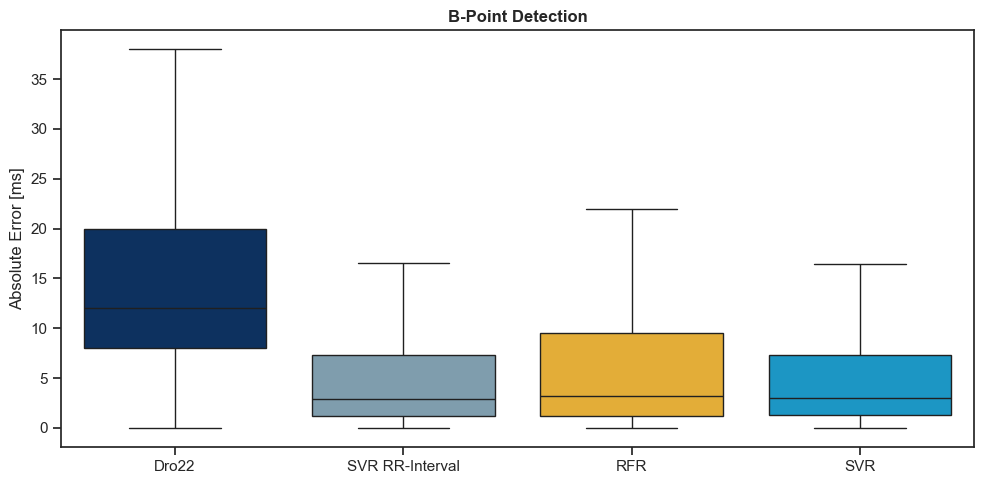

In [104]:
sns.boxplot(plot_data, showfliers=False)
plt.ylabel("Absolute Error [ms]")
plt.title("B-Point Detection", fontdict={"weight": "bold"})
plt.tight_layout()

Boxplot of the best performing traditional- + ml-estimators by Empkins Dataset

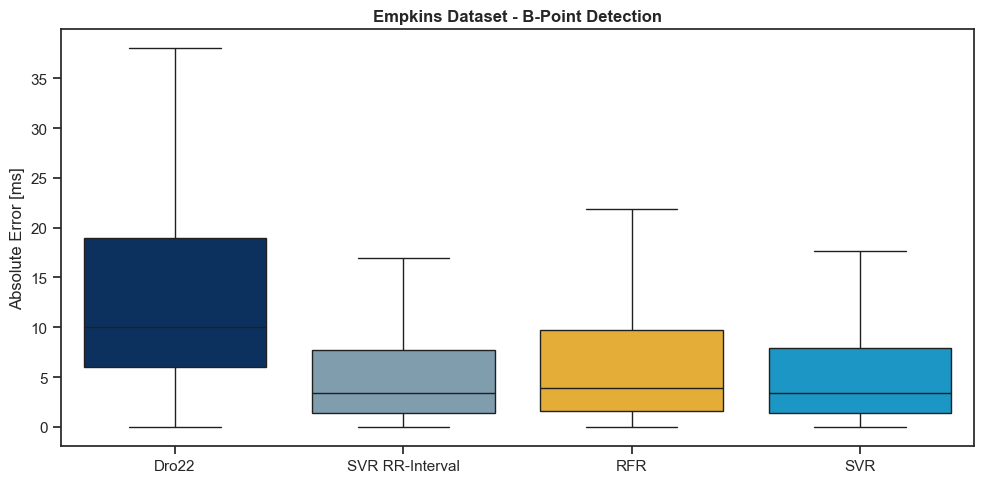

In [ ]:
sns.boxplot(empkins_data, showfliers=False)
plt.ylabel("Absolute Error [ms]")
plt.title("Empkins Dataset - B-Point Detection", fontdict={"weight": "bold"})
plt.tight_layout()

Boxplot of the best performing traditional- + ml-estimators by Guardian Dataset

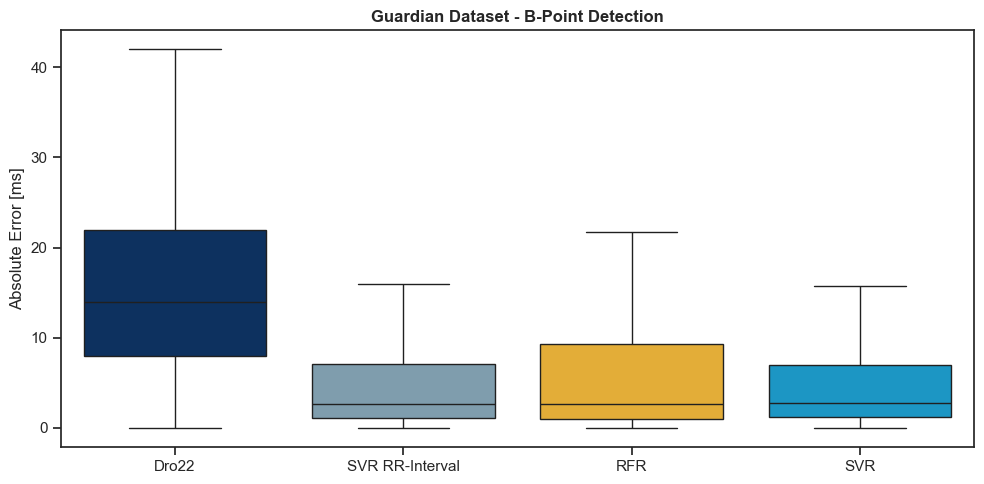

In [ ]:
sns.boxplot(guardian_data, showfliers=False)
plt.ylabel("Absolute Error [ms]")
plt.title("Guardian Dataset - B-Point Detection", fontdict={"weight": "bold"})
plt.tight_layout()

Does the best ml-estimator reflect changes in the B-Point location over different conditions

Empkins

<Axes: xlabel='condition', ylabel='SVR RR-Interval'>

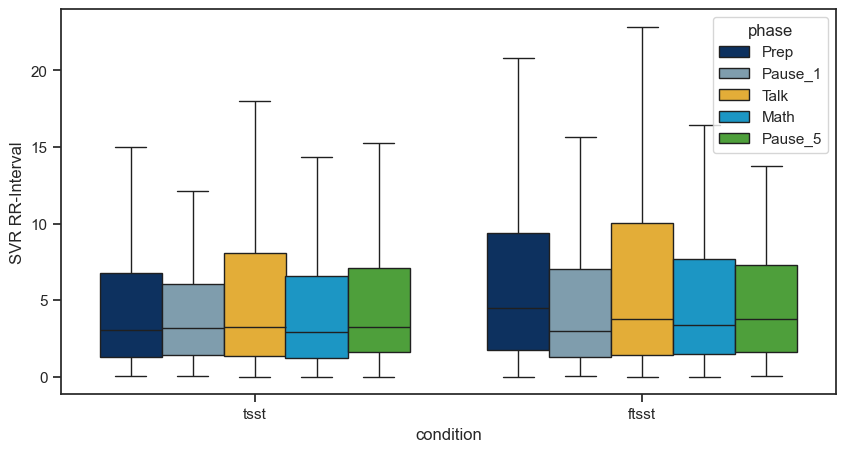

In [120]:
sns.boxplot(empkins_data, x="condition", y="SVR RR-Interval", hue="phase", order=["tsst", "ftsst"], hue_order=["Prep", "Pause_1", "Talk", "Math", "Pause_5"], showfliers=False)

Guardian

<Axes: xlabel='phase', ylabel='SVR RR-Interval'>

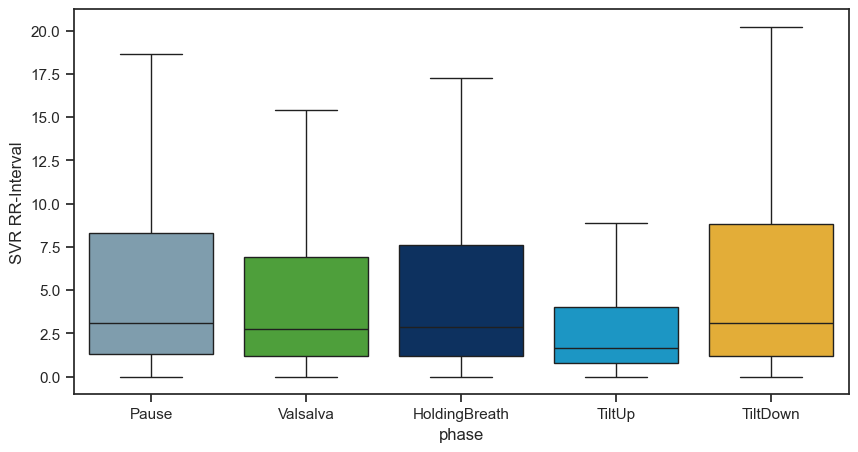

In [128]:
sns.boxplot(guardian_data, x="phase", y="SVR RR-Interval", hue="phase", order=["Pause", "Valsalva", "HoldingBreath", "TiltUp", "TiltDown"], showfliers=False, palette=palette[:-1], legend=False)

Residualplots of the best performing traditional- + ml-estimators against the B-Point reference

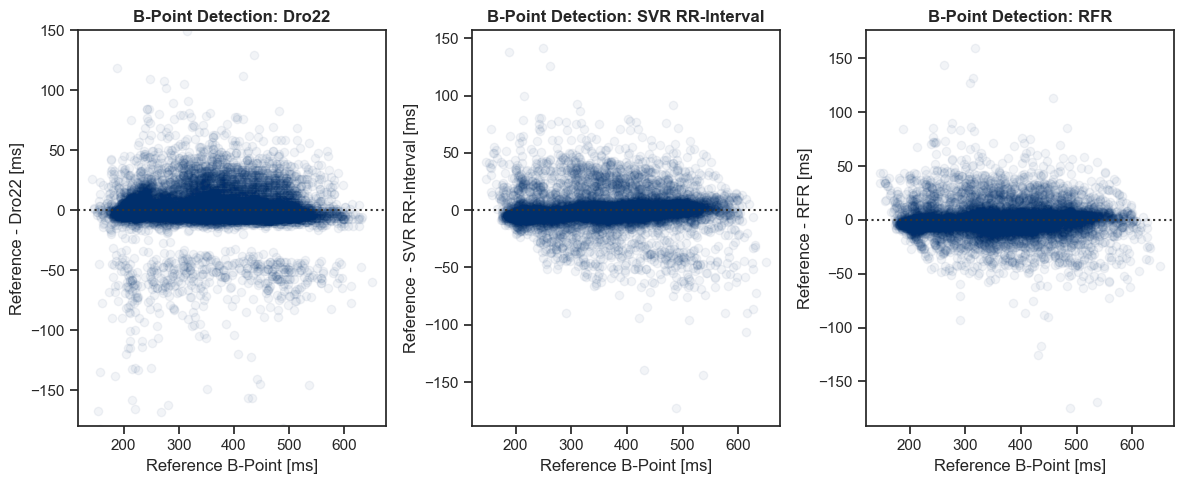

In [141]:
fig, axs = plt.subplots(1, 3, figsize=(12,5))
sns.residplot(merged_ml_results_b_point, x="b_point_sample_reference", y="drost2022", ax=axs[0], scatter_kws={"alpha": 0.05})
axs[0].set_ylabel("Reference - Dro22 [ms]")
axs[0].set_xlabel("Reference B-Point [ms]")
axs[0].set_ylim(-180, 150)
axs[0].set_title("B-Point Detection: Dro22", fontdict={"weight": "bold"})
sns.residplot(merged_ml_results_b_point, x="b_point_sample_reference", y="SS_SFM_SVR_RR-Interval", ax=axs[1], scatter_kws={"alpha": 0.05})
axs[1].set_ylabel("Reference - SVR RR-Interval [ms]")
axs[1].set_xlabel("Reference B-Point [ms]")
axs[1].set_title("B-Point Detection: SVR RR-Interval", fontdict={"weight": "bold"})
sns.residplot(merged_ml_results_b_point, x ="b_point_sample_reference", y="SS_KBest_RFR_Without-RR-Interval", ax=axs[2], scatter_kws={"alpha": 0.05})
axs[2].set_ylabel("Reference - RFR [ms]")
axs[2].set_xlabel("Reference B-Point [ms]")
axs[2].set_title("B-Point Detection: RFR", fontdict={"weight": "bold"})
fig.tight_layout()